# Ice Floe Segmentation and Tracking Algorithm

The Segmentaion Tracking Combined notebook is a tutorial that serves to demonstrate the full workflow of the segmentation and tracking algotrithms, beginning with satellite images and producing various representations of the tracked floes. A more in depth tutorial on the segmentation process itself can be found at https://wilhelmuslab.github.io/IceFloeTracker.jl/tutorials/lopez-acosta-2019-workflow/  

This tutorial is split into two main sections, the first of which is the segmentation algorithm which takes the satellite photos, identifies the ice floes, and produces binary images with identified floes. These binary images are then loaded into the second section of the tutorial which tracks the movement of the ice floes from image to image, and producing various representations of the tracked floes' movement over time.

### Environment Setup

First we begin by setting up the Environment. We install packages such as IceFloeTracker which contain the functions that will be used throughout the notebook, then load the packages in to use them.

In [1]:
using Pkg
Pkg.add(;name="IceFloeTracker", rev="main")
Pkg.add("Images")

    Updating git-repo `https://github.com/WilhelmusLab/IceFloeTracker.jl.git`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [2]:
Pkg.add("Dates")
Pkg.add("Plots")
Pkg.add("DataFrames")

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [4]:
using IceFloeTracker;
using Images;
using Images: segment_mean, labels_map, SegmentedImage, RGB;

In [5]:
# Functions for prepping the region props tables, and tracking floes
using IceFloeTracker: addfloemasks!, adduuid!, add_passtimes!, addψs!, long_tracker

In [6]:
using DataFrames, Dates

In [ ]:
#using Plots - for some reason this is currently crashing my kernel

In [7]:
Pkg.add("CairoMakie")

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [8]:
using CairoMakie;

# Segmentation Algorithm

The Segmentation Tracking Combined tutorial includes one demonstration image preprocessing and segmentation. We begin by loading a dataset that of satellite images. We can then select a case, or pair of images, that we would like to study. We then do some preprocessing of the images and finally load them into the segmentation algorithm. After the images have been segmented, we can produce the binary images that will be used in the tracking section.

### Loading Images

Now that the environment is setup, we load the dataset with the satellite photos from https://github.com/danielmwatkins/ice_floe_validation_dataset using the Watkins2025GitHub data loader.

In [9]:
data_loader = Watkins2025GitHub(; ref="b865acc62f223d6ff14a073a297d682c4c034e5d")

Watkins2025GitHub("b865acc62f223d6ff14a073a297d682c4c034e5d", "https://github.com/danielmwatkins/ice_floe_validation_dataset/", "data/validation_dataset/validation_dataset.csv", "/tmp/Watkins2025")

In [10]:
data_loader().metadata

378×30 DataFrame
 Row │        case_number  region          start_date  center_lon  center_lat  ⋯
     │ Int64  Int64        String          Date        Float64     Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0            1  baffin_bay      2022-09-11    -91.5275     77.801   ⋯
   2 │     1            1  baffin_bay      2022-09-11    -91.5275     77.801
   3 │     2            2  baffin_bay      2015-03-12    -81.9643     76.0579
   4 │     3            2  baffin_bay      2015-03-12    -81.9643     76.0579
   5 │     4            3  baffin_bay      2012-04-19    -79.5793     75.6372  ⋯
   6 │     5            3  baffin_bay      2012-04-19    -79.5793     75.6372
   7 │     6            4  baffin_bay      2019-09-25    -76.8094     79.3029
   8 │     7            4  baffin_bay      2019-09-25    -76.8094     79.3029
   9 │     8            5  baffin_bay      2013-03-08    -74.8142     78.2037  ⋯
  10 │     9            5  baffin_bay      2013-03-08    -74.8142     78.2037
  11 │    10            6  baffin_bay      2022-05-30    -73.3612     75.2608
  ⋮  │   ⋮         ⋮             ⋮             ⋮           ⋮           ⋮       ⋱
 369 │   368          185  sea_of_okhostk  2011-05-04    154.474      58.5899
 370 │   369          185  sea_of_okhostk  2011-05-04    154.474      58.5899  ⋯
 371 │   370          186  sea_of_okhostk  2017-05-23    155.183      59.6011
 372 │   371          186  sea_of_okhostk  2017-05-23    155.183      59.6011
 373 │   372          187  sea_of_okhostk  2013-04-29    155.731      59.7278
 374 │   373          187  sea_of_okhostk  2013-04-29    155.731      59.7278  ⋯
 375 │   374          188  sea_of_okhostk  2015-03-12    156.838      57.6608
 376 │   375          188  sea_of_okhostk  2015-03-12    156.838      57.6608
 377 │   376          189  sea_of_okhostk  2012-04-26    163.086      61.4172
 378 │   377          189  sea_of_okhostk  2012-04-26    163.086      61.4172  ⋯
                                                 24 columns and 357 rows omitted

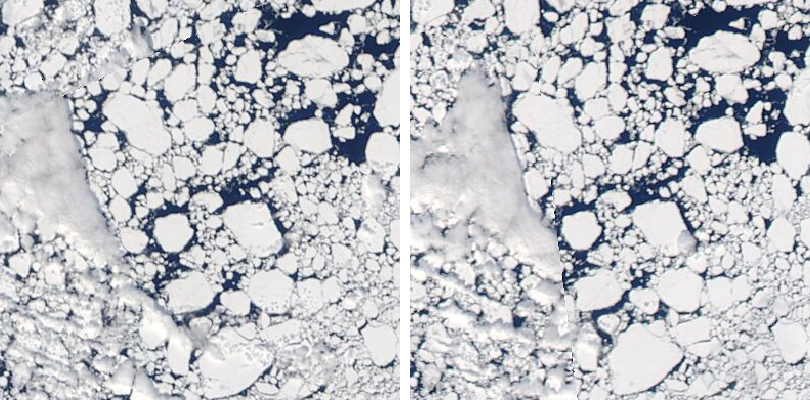

In [11]:
# Select a case number

cn = 6;

dataset3 = data_loader(c-> c.case_number == cn);
case1 = first(dataset3);
case2 = last(collect(dataset3.data));
mosaicview(case1.modis_truecolor, case2.modis_truecolor, nrow=1, npad=10)

In [12]:
# Preprocessing
truecolor1 = RGB.(case1.modis_truecolor);
truecolor2 = RGB.(case2.modis_truecolor);
falsecolor1 = RGB.(case1.modis_falsecolor);
falsecolor2 = RGB.(case2.modis_falsecolor);
landmask1 = RGB.(case1.modis_landmask); 
landmask2 = RGB.(case2.modis_landmask);

In [13]:
# Run the segmentation algorithm
segmentation_algorithm = LopezAcosta2019Tiling.Segment();

In [14]:
segments1 = segmentation_algorithm(truecolor1, falsecolor1, landmask1);
segments2 = segmentation_algorithm(truecolor2, falsecolor2, landmask2);

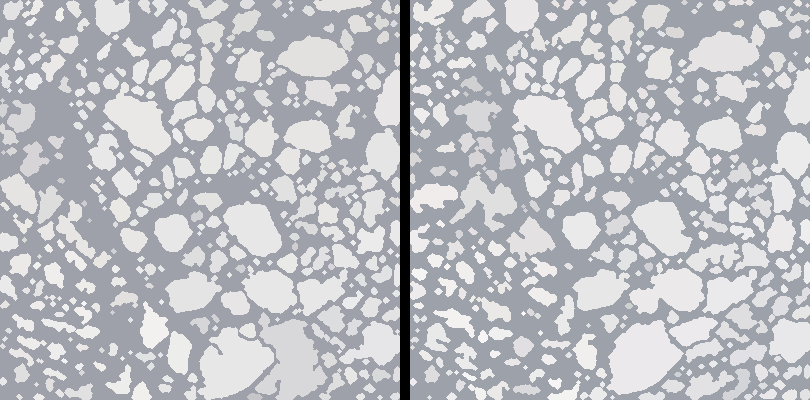

In [15]:
function view_seg(s)
    map(i->segment_mean(s,i), labels_map(s))
end

mosaicview(view_seg(segments1), view_seg(segments2), nrow=1, npad=10)

2-element Vector{Matrix{Gray{Bool}}}:
 [Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(false) Gray{Bool}(false); Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(false) Gray{Bool}(false); … ; Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(true) Gray{Bool}(false); Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(false) Gray{Bool}(false)]
 [Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(false) Gray{Bool}(false); Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(false) Gray{Bool}(false); … ; Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(true) Gray{Bool}(false); Gray{Bool}(false) Gray{Bool}(false) … Gray{Bool}(false) Gray{Bool}(false)]
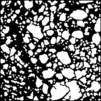
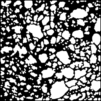

In [16]:
# Converting segmented images into binary images for tracking
binaryimg1 = Gray.(labels_map(segments1) .> 0);
binaryimg2 = Gray.(labels_map(segments2) .> 0);
images = [binaryimg1, binaryimg2] 

# Tracking Algorithm

In the tracking section, we begin by using a few functions from the IceFloeTracker package to extract features from the sequence of binary images, then add the additional information to the image's property table, then pass the images into the tracking algorithm. From here we get can produce a few different visualizations of the tracked floes which we have included.


We begin by measuring the object properties. The example images are binary, so we need to label the connected components before extracting the region properties.

In [17]:
labeled_images = label_components.(images);

In [18]:
labeled_images = label_components.(images);
props = regionprops_table.(labeled_images);

In [19]:
# Property table  with information about the identified floes
props[1]

347×12 DataFrame
 Row │ area     min_row  min_col  max_row  max_col  row_centroid  col_centroid ⋯
     │ Float64  Int64    Int64    Int64    Int64    Int64         Int64        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   237.0       29        1       55       15            43             8 ⋯
   2 │   174.0       64        1       89       12            77             6
   3 │   101.0       99        1      118        9           109             4
   4 │   211.0      124        1      145       19           136             9
   5 │   888.0      174        1      214       38           194            20 ⋯
   6 │    46.0      203        1      211       10           207             6
   7 │   279.0      233        1      252       19           243             9
   8 │   253.0      276        1      301       18           288             8
   9 │    49.0      301        1      309       10           305             5 ⋯
  10 │    21.0      344        1      349        6           347             3
  11 │    44.0      378        1      386        7           382             4
  ⋮  │    ⋮        ⋮        ⋮        ⋮        ⋮          ⋮             ⋮       ⋱
 338 │   214.0      221      390      247      400           233           396
 339 │    34.0       21      391       27      398            24           394 ⋯
 340 │    58.0      393      391      400      400           397           396
 341 │    99.0      178      392      193      400           185           397
 342 │    38.0      291      393      297      400           294           397
 343 │    89.0      367      394      382      400           375           397 ⋯
 344 │    21.0       33      395       38      400            35           398
 345 │    65.0       53      395       67      400            60           398
 346 │   125.0      264      395      287      400           276           398
 347 │    13.0      254      396      258      400           256           398 ⋯
                                                  5 columns and 326 rows omitted

In [20]:
# Adding more information to property tables

passtimes = (dataset3.metadata.pass_time[1],dataset3.metadata.pass_time[2]);
add_passtimes!(props, passtimes);
adduuid!(props);
addfloemasks!(props, [segments1.image_indexmap .> 0, segments2.image_indexmap .> 0])
addψs!(props)

In [21]:
props[1][!, :bdry] = IceFloeTracker.bwtraceboundary.(props[1][!, :mask]);
props[2][!, :bdry] = IceFloeTracker.bwtraceboundary.(props[2][!, :mask]);

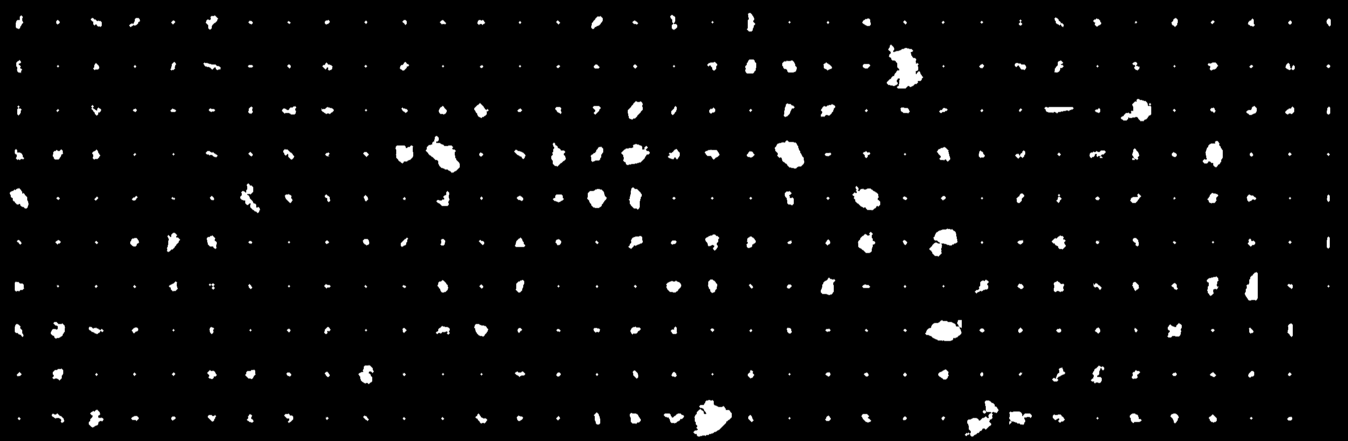

In [22]:
# Here we can see all the identified Ice Floes that are being tracked

mosaicview([Gray.(m) for m in props[1].mask], nrow=10)

In [35]:
# We can produce a Psi curve as a way to observe the boundary shape of the ice floe

plt = Plots.plot([p[1,:psi] for p in props], lc=:black)
Plots.plot!([p[2,:psi] for p in props], lc=:red)

LoadError: UndefVarError: `Plots` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
ct = IceFloeTracker.candidate_filter_settings;
mc = IceFloeTracker.candidate_matching_settings;

In [24]:
#Running the tracking algorithm

tracked = long_tracker(props, ct, mc);

┌ Warning: correlation too low, c: 0.9481182849845589
└ @ IceFloeTracker.Tracking ~/.julia/packages/IceFloeTracker/FuHr6/src/Tracking/matchcorr.jl:50
┌ Warning: correlation too low, c: 0.9075357507100561
└ @ IceFloeTracker.Tracking ~/.julia/packages/IceFloeTracker/FuHr6/src/Tracking/matchcorr.jl:50
┌ Warning: correlation too low, c: 0.9026828251413623
└ @ IceFloeTracker.Tracking ~/.julia/packages/IceFloeTracker/FuHr6/src/Tracking/matchcorr.jl:50
┌ Warning: correlation too low, c: 0.9121539506750675
└ @ IceFloeTracker.Tracking ~/.julia/packages/IceFloeTracker/FuHr6/src/Tracking/matchcorr.jl:50
┌ Warning: correlation too low, c: 0.9182860468101136
└ @ IceFloeTracker.Tracking ~/.julia/packages/IceFloeTracker/FuHr6/src/Tracking/matchcorr.jl:50
┌ Warning: correlation too low, c: 0.8895249829706161
└ @ IceFloeTracker.Tracking ~/.julia/packages/IceFloeTracker/FuHr6/src/Tracking/matchcorr.jl:50
┌ Warning: correlation too low, c: 0.9391504647810865
└ @ IceFloeTracker.Tracking ~/.julia/packages/

In [27]:
tg = groupby(tracked, :ID);

In [40]:
# We can also produce a graph that shows the distace traveled by the centriods of two identified floes

plot(tg[1][!, :col_centroid], tg[1][!, :row_centroid], m=:circle, markersize=4, label="Floe 1")
Plots.plot!(tg[2][!, :col_centroid], tg[1][!, :row_centroid], m=:circle, markersize=4, label="Floe 2")

LoadError: Invalid attribute [31m[1mm[22m[39m for plot type [34m[1mScatter{Tuple{Vector{Point{2, Float64}}}}[22m[39m.

The available plot attributes for Scatter{Tuple{Vector{Point{2, Float64}}}} are:

alpha        depthsorting   inspector_clear  model        transform_marker
clip_planes  distancefield  inspector_hover  nan_color    transformation  
color        font           inspector_label  overdraw     transparency    
colormap     fxaa           lowclip          rotation     uv_offset_width 
colorrange   glowcolor      marker           space        visible         
colorscale   glowwidth      marker_offset    ssao                         
cycle        highclip       markersize       strokecolor                  
depth_shift  inspectable    markerspace      strokewidth                  



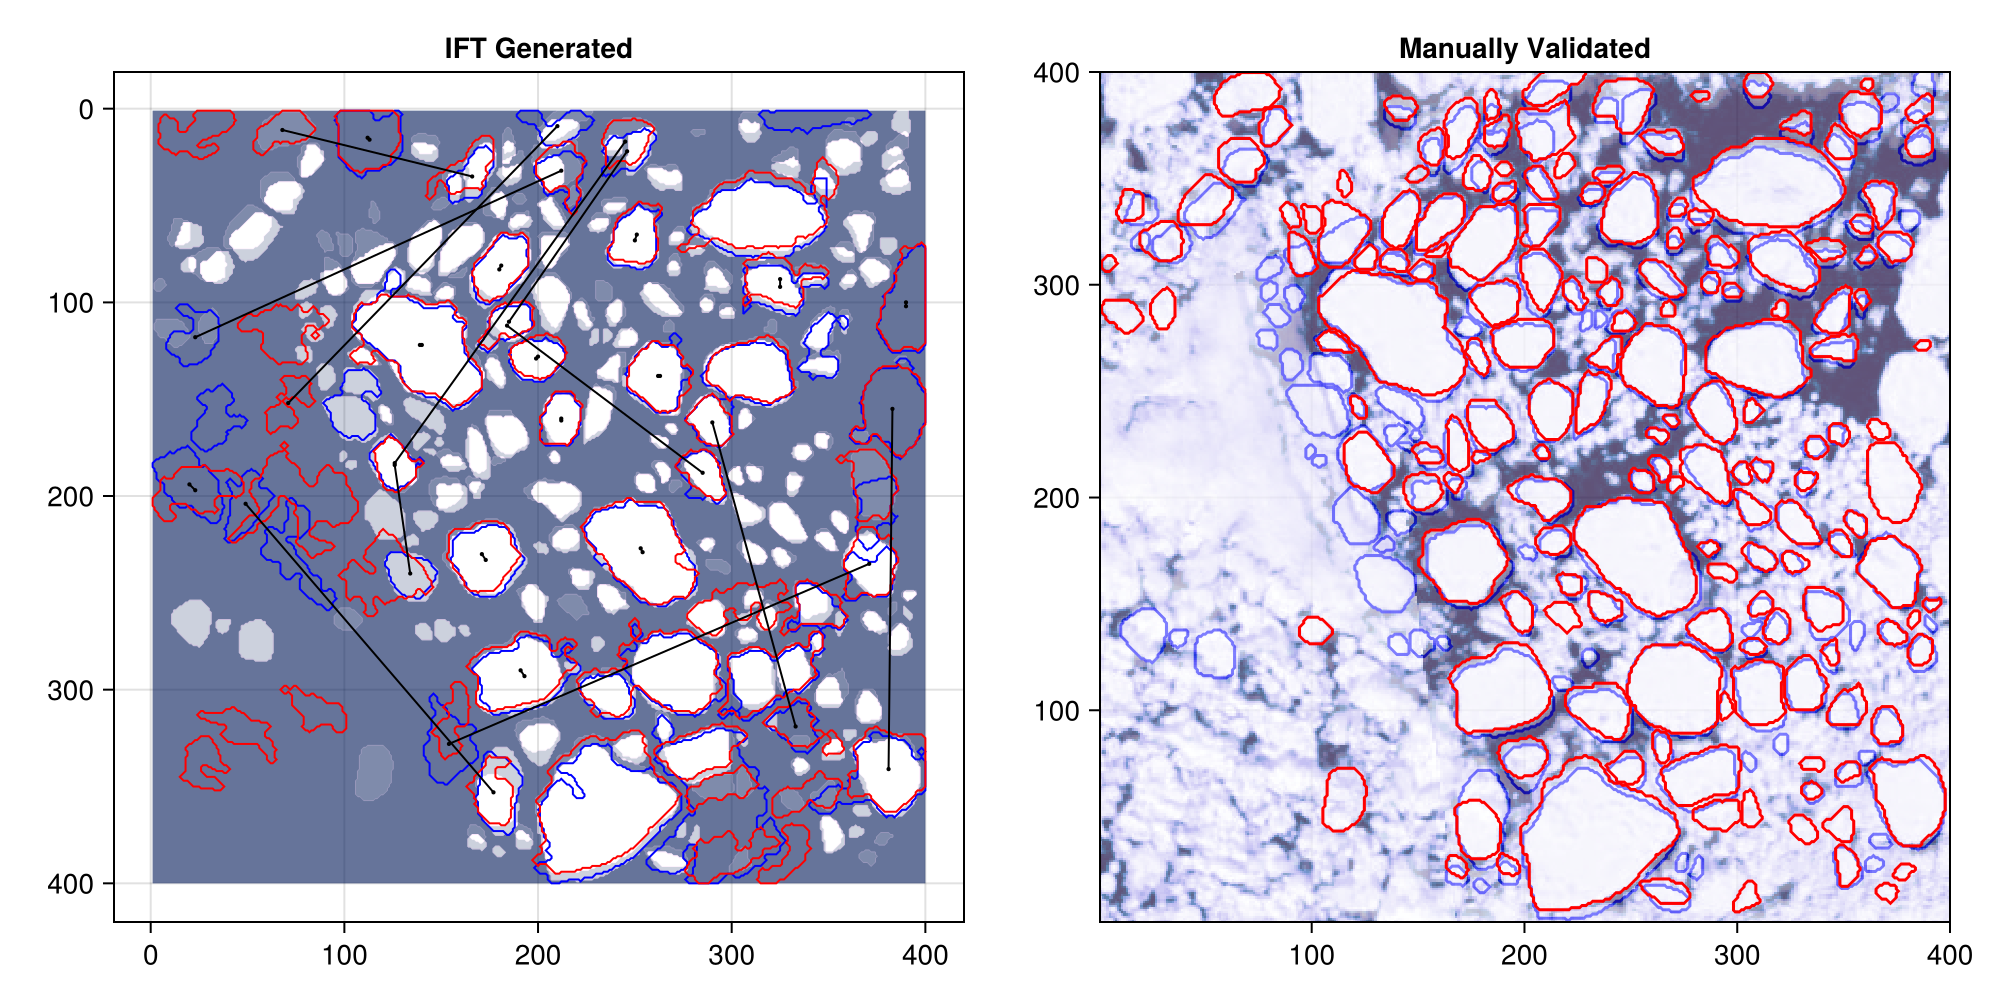

CairoMakie.Screen{IMAGE}


In [25]:
# Now we can produce a nice visualization comparing the IFT generated tracked floes with and image of the manually identified floes

terra = case1
aqua = case2;

# color options: https://docs.makie.org/dev/explanations/colors

# Initialize figure object
f = Figure(size=(1000, 500))

# Add two panels and give them titles
ax1 = CairoMakie.Axis(f[1, 1], aspect = 1, title="IFT Generated")
ax2 = CairoMakie.Axis(f[1, 2], aspect = 1, title="Manually Validated")
   
#IFT generated tracked image
idx = tracked.trajectory_uuid[1]
track_data = filter(r -> r.trajectory_uuid == idx, tracked);

ax1.yreversed = true
floes = terra.validated_binary_floes .> 0
CairoMakie.contourf!(ax1, rotr90(reverse(floes, dims=1)), levels = 0:0.5:1, colormap=(:batlow, 0.5))   
floes = aqua.validated_binary_floes .> 0
CairoMakie.contourf!(ax1, rotr90(reverse(floes, dims=1)), levels = 0:0.5:1, colormap=(:batlow, 0.2))   
for (props_df, color) in zip(props, [:blue, :red])
    for floe_data in eachrow(props_df)
        floe = floe_data.bdry
        rc = floe_data.min_row - 1
        cc = floe_data.min_col - 1
        lines!(ax1, getindex.(floe[1], 2) .+ cc, getindex.(floe[1], 1) .+ rc, color=color, linewidth=1)
    end
end
for traj_id in unique(tracked.trajectory_uuid)
    traj_data = filter(r -> r.trajectory_uuid == traj_id, tracked);
    scatterlines!(ax1, traj_data.col_centroid, traj_data.row_centroid, marker=:circle, markersize=3, color=:black, linewidth=1)
end
CairoMakie.ylims!(400, 0.5)
CairoMakie.xlims!(0.5, 400)

# Plot the Terra data. First, we get the binary floes as a bitmatrix
floes = terra.validated_binary_floes .> 0

# Then we plot the image using the "heatmap" function. Here I'm using Band 2 which has
# high contrast between water and ice.
CairoMakie.heatmap!(ax2, rotr90(green.(terra.modis_falsecolor)), 
        colormap=(:devon, 0.5), colorrange=(0, 1))

# Now we draw the Terra floe outlines using a contour plot. This method draws lines at
# places where the image gradient is large. In a binary image, it's all 0 or 1, so using
# levels = 0, 0.5, 1 forces it to draw lines along the edges of bright spots.
CairoMakie.contour!(ax2, rotr90(floes), color = :blue, levels = 0:0.5:1)   

# Now do the same for the Aqua images
floes = aqua.validated_binary_floes .> 0
CairoMakie.heatmap!(ax2, rotr90(green.(aqua.modis_falsecolor)),  
        colormap=(:devon, 0.5), colorrange=(0, 1))
CairoMakie.contour!(ax2, rotr90(floes), color = :red, levels = 0:0.5:1)

ax2.yreversed = false

# Finally we show the figure.
# We could also save it with the command save("image_name.png", f)
display(f)